# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor

### Чем мы будем заниматься?
Создадим модель, использующую алгоритмы машинного обучения. Код для создания и обучения модели предоставлен в готовом виде: в нём не будет предусмотрен подбор параметров и тонкая настройка модели. Алгоритм машинного обучения — RandomForestRegression. Наша задача состоит в том, чтобы качественно подготовить данные для обучения модели. Очистка данных и генерация новых признаков (Feature Engineering) способны значительно повысить точность модели.


### Какой кейс решаем?

Представьте, что вы работаете DS в компании TripAdvisor. Одна из проблем компании — это нечестные рестораны, которые накручивают себе рейтинг. Одним из способов нахождения таких ресторанов является построение модели, которая предсказывает рейтинг ресторана. Если предсказания модели сильно отличаются от фактического результата, то, возможно, ресторан играет нечестно, и его стоит проверить.

Вам поставлена задача создать такую модель.

### Разбираемся с данными
Датасет содержит сведения о 40 000 ресторанах Европы, а модель, которую мы будем обучать, должна будет предсказывать рейтинг ресторана по данным сайта TripAdvisor на основе имеющихся в датасете данных.

Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:

* **Restaurant_id** — идентификационный номер ресторана / сети ресторанов;
* **City** — город, в котором находится ресторан;
* **Cuisine Style** — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
* **Ranking** — место, которое занимает данный ресторан среди всех ресторанов своего города;
* **Rating** — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
* **Price Range** — диапазон цен в ресторане;
* **Number of Reviews** — количество отзывов о ресторане;
* **Reviews** — данные о двух отзывах, которые отображаются на сайте ресторана;
* **URL_TA** — URL страницы ресторана на TripAdvisor;
* **ID_TA** — идентификатор ресторана в базе данных TripAdvisor.

### Что мы сделаем на этом шаге?
Загрузим необходимые библиотеки.
Загрузим тренировочный и тестовый датасеты.
Посмотрим на данные.
Посмотрим, где у нас пропуски.
Определим тип признаков.

# import

In [1]:
import numpy as np  # Linear algebra
import pandas as pd  # Data processing

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import re
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import warnings
from scipy.stats import norm
from collections import Counter

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.set_option('display.max_rows', 50)  # Показывать больше строк
pd.set_option('display.max_columns', 50)  # Показывать больше колонок

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# Зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

In [3]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

In [4]:
def outliers_iqr(ys):
    # Функция определения выбросов по методу межквартильного расстояния
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]


def outliers_z_score(ys, threshold=3):
    # Функция определения выбросов по отклонению от среднего значения
    mean_y = np.mean(ys)
    std_y = np.std(ys)
    z_scores = [(y - mean_y) / std_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)[0]

# DATA
Загрузим тренировочный и тестовый датасеты

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


Таким образом, тренировочный и тестовый датасеты содержат 40000 и 10000 записей соответственно. Оба датасета имеют пропуски в данных.

* **df_train** имеет пропуски в признаках: '**Cuisine Style**', '**Price Range**', '**Number of Reviews**'
* **df_test** имеет пропуски в признаках: '**Cuisine Style**', '**Price Range**', '**Number of Reviews**', '**Reviews**'

In [10]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [12]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # Помечаем где у нас трейн
df_test['sample'] = 0  # Помечаем где у нас тест
# В тесте нет значения Rating, его нужно предсказать, поэтому заполняем нулями
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # Объединяем

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [14]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
14966,id_8691,London,['Healthy'],8700.0,$,11.0,"[['Great little friut and veg stall.', 'Birthd...",/Restaurant_Review-g186338-d3175646-Reviews-El...,d3175646,1,4.5
15642,id_304,Madrid,"['Peruvian', 'Latin', 'Seafood', 'Mediterranea...",305.0,$$ - $$$,402.0,"[['Navaja', 'Amazing food'], ['04/20/2017', '0...",/Restaurant_Review-g187514-d8389687-Reviews-RE...,d8389687,1,4.5
3143,id_3143,Lisbon,NaN,3084.0,NaN,48.0,"[['Great view, good burgers, friendly staff', ...",/Restaurant_Review-g189158-d10636375-Reviews-B...,d10636375,0,0.0
43607,id_518,Hamburg,"['German', 'European', 'Central European']",519.0,$$ - $$$,51.0,"[['Very friendly service staff', 'Informal, go...",/Restaurant_Review-g187331-d1346209-Reviews-Jo...,d1346209,1,4.0
43519,id_2342,Munich,['European'],2358.0,NaN,5.0,"[['-'], ['08/07/2016']]",/Restaurant_Review-g187309-d969823-Reviews-Der...,d969823,1,3.0


In [15]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Большинство признаков требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   

## 1. Переименование столбцов и обработка NAN
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
Поэтому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [16]:
# Приведем заголовки столбцов в нижний регистр
# с нижним подчеркиванием в качестве разделителя слов.
data.columns = ['restaurant_id', 'city', 'cuisine_style', 'ranking',
                'price_range', 'number_of_reviews', 'reviews', 'url_ta',
                'id_ta', 'sample', 'rating']
data.sample(3)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating
1544,id_1544,Barcelona,['Pizza'],3524.0,$,57.0,"[[], []]",/Restaurant_Review-g187497-d3984285-Reviews-Pi...,d3984285,0,0.0
2985,id_2985,Warsaw,"['Asian', 'Thai', 'Vegetarian Friendly', 'Vega...",87.0,$$$$,257.0,"[['Very good', 'Lovely food, nice service'], [...",/Restaurant_Review-g274856-d4259877-Reviews-Th...,d4259877,0,0.0
8342,id_8342,Paris,"['Italian', 'Pizza', 'Kosher']",8707.0,$,29.0,"[['Not bad'], ['07/26/2015']]",/Restaurant_Review-g187147-d7694463-Reviews-Il...,d7694463,0,0.0


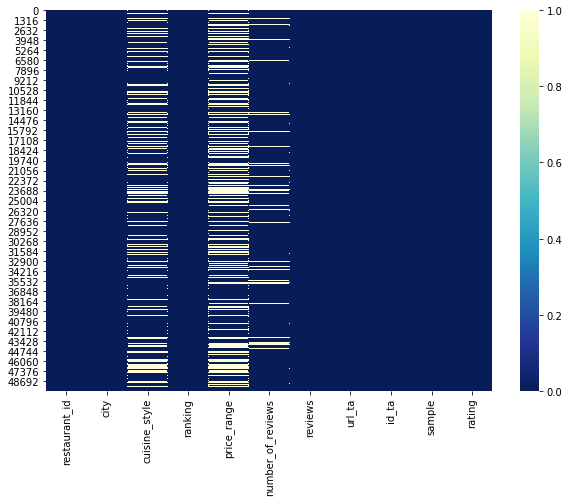

In [17]:
# Посмотрим как распределены пропуски по датасету
plt.figure(figsize=(10, 7))
sns.heatmap(data.isnull(), cmap="YlGnBu_r")

Пропуски присутствуют в трех признаках.


## Признак "number_of_reviews"

In [18]:
# Создаем новый признак с информацией о пропусках в "number_of_reviews"
data['number_of_reviews_isnan'] = pd.isna(
    data['number_of_reviews']).astype('uint8')

In [19]:
data['number_of_reviews_isnan']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: number_of_reviews_isnan, Length: 50000, dtype: uint8

In [20]:
data['number_of_reviews_isnan'].value_counts()

0    46800
1     3200
Name: number_of_reviews_isnan, dtype: int64

In [21]:
# Далее заполняем пропуски 0
data['number_of_reviews'].fillna(0, inplace=True)

In [22]:
data['number_of_reviews'].isna().value_counts()

False    50000
Name: number_of_reviews, dtype: int64

## Признак "price_range"

In [23]:
# Cоздаем признак 'price_range_isnan', который содержит инфо о пропусках
data['price_range_isnan'] = pd.isna(data['price_range']).astype('uint8')

In [24]:
# Для заполнения пропусков находим самое распространенное значение признака
data['price_range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: price_range, dtype: int64

In [25]:
# Заполняем пропуски средним ценовым диапазоном
data['price_range'] = data['price_range'].fillna('$$ - $$$')

In [26]:
# Проверяем
data['price_range'].isna().value_counts()

False    50000
Name: price_range, dtype: int64

## Признак "cuisine_style".

In [27]:
# Создаем признак 'cuisine_style_isnan', который содержит инфо о пропусках
data['cuisine_style_isnan'] = pd.isna(data['cuisine_style']).astype('uint8')

In [28]:
data['cuisine_style_isnan'].value_counts()

0    38410
1    11590
Name: cuisine_style_isnan, dtype: int64

In [29]:
# Если в ресторане не заполнена информация о типах кухни, которую готовят, 
# можно предположить, что в этом ресторане только местная кухня. 
# Поэтому заменили ее константой Local.
data['cuisine_style'] = data['cuisine_style'].fillna("['Local']")

In [30]:
data['cuisine_style'].isna().value_counts()

False    50000
Name: cuisine_style, dtype: int64

## 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [31]:
data.nunique(dropna=False)

restaurant_id              13094
city                          31
cuisine_style              10732
ranking                    12975
price_range                    3
number_of_reviews           1574
reviews                    41858
url_ta                     49963
id_ta                      49963
sample                         2
rating                        10
number_of_reviews_isnan        2
price_range_isnan              2
cuisine_style_isnan            2
dtype: int64

В качестве категориальных рассмотрим признак:

* 'city' - 31 город в датасете - закодируем

## Признак "city"

In [32]:
# Сначала делаем копию столбца 'city' - она нам потом пригодится
data['city_copy'] = data['city']

In [33]:
# Количество городов в датасете
amount_of_cities = len(data['city'].unique())
# Переводим города в dummy-переменные,'nan' не используем,
# т.к. признак 'city' не имеет пропусков
# Для кодирования используем подход "One-Hot Encoding"
data = pd.get_dummies(data, columns=['city'],
                      prefix='', prefix_sep='', dummy_na=False)
city_sum = {}  # Создаем словарь с количеством ресторанов по городам
for city in data.columns[-amount_of_cities:]:
    city_sum[city] = data[city].sum()
print("Количество ресторанов по городам:", city_sum)

Количество ресторанов по городам: {'Amsterdam': 1372, 'Athens': 776, 'Barcelona': 3395, 'Berlin': 2705, 'Bratislava': 380, 'Brussels': 1314, 'Budapest': 1021, 'Copenhagen': 819, 'Dublin': 836, 'Edinburgh': 745, 'Geneva': 590, 'Hamburg': 1186, 'Helsinki': 475, 'Krakow': 554, 'Lisbon': 1647, 'Ljubljana': 222, 'London': 7193, 'Luxembourg': 263, 'Lyon': 1126, 'Madrid': 3813, 'Milan': 2694, 'Munich': 1145, 'Oporto': 642, 'Oslo': 488, 'Paris': 6108, 'Prague': 1816, 'Rome': 2589, 'Stockholm': 1033, 'Vienna': 1443, 'Warsaw': 925, 'Zurich': 685}


In [34]:
data.sample(3)

,restaurant_id,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,number_of_reviews_isnan,price_range_isnan,cuisine_style_isnan,city_copy,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
47774,id_2762,['Steakhouse'],2768.0,$$ - $$$,3.0,"[['Great food', 'A really great / different ex...",/Restaurant_Review-g274707-d4937603-Reviews-Mo...,d4937603,1,4.5,0,1,0,Prague,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
35414,id_857,['Cafe'],858.0,$,26.0,"[['Good!!!!', 'Only a beer!!!'], ['11/17/2017'...",/Restaurant_Review-g187265-d911428-Reviews-L_E...,d911428,1,4.5,0,0,0,Lyon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
28332,id_5985,"['Japanese', 'Seafood']",5986.0,$$ - $$$,18.0,[['Beautiful interior and fish in lovely Born'...,/Restaurant_Review-g187497-d3494602-Reviews-Bi...,d3494602,1,3.5,0,1,0,Barcelona,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Признак "price_range".

In [35]:
data['price_range'].value_counts(dropna=False)

$$ - $$$    40402
$            7816
$$$$         1782
Name: price_range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1, 2, 3  

In [36]:
# Замена значений в 'price_range' на цифры 1, 2, 3
dict_price = {'$' : '1', '$$ - $$$' : '2', '$$$$' : '3'}
data['price_range'] = data['price_range'].map(dict_price)
data['price_range'] = data['price_range'].astype('uint8')

In [37]:
data['price_range'].value_counts(dropna=False)

2    40402
1     7816
3     1782
Name: price_range, dtype: int64

##  Признак "cuisine_style"

In [38]:
# Получаем из строк в столбце Cuisine Style - списки
data['cuisine_style'] = data['cuisine_style'].apply(lambda x: eval(x))

In [39]:
# Добавим признак с количеством типов кухонь
data['len_cuisines'] = data['cuisine_style'].apply(lambda x: len(x))
data['len_cuisines']

0        2
1        5
2        1
3        5
4        6
        ..
49995    4
49996    5
49997    2
49998    5
49999    1
Name: len_cuisines, Length: 50000, dtype: int64

In [40]:
# Добавим дамми переменные по типам кухонь:
style = data['cuisine_style'].explode()
X = pd.get_dummies(style)
index_list = pd.Index.tolist(X.index)
Y = X.groupby(index_list).sum()
data = data.join(Y)

In [41]:
# Получим список всех кухонь
cuisine_list = np.sort(data.cuisine_style.explode().unique())
cuisine_list

array(['Afghani', 'African', 'Albanian', 'American', 'Arabic',
       'Argentinean', 'Armenian', 'Asian', 'Australian', 'Austrian',
       'Azerbaijani', 'Balti', 'Bangladeshi', 'Bar', 'Barbecue',
       'Belgian', 'Brazilian', 'Brew Pub', 'British', 'Burmese', 'Cafe',
       'Cajun & Creole', 'Cambodian', 'Canadian', 'Caribbean',
       'Caucasian', 'Central American', 'Central Asian',
       'Central European', 'Chilean', 'Chinese', 'Colombian',
       'Contemporary', 'Croatian', 'Cuban', 'Czech', 'Danish',
       'Delicatessen', 'Diner', 'Dutch', 'Eastern European', 'Ecuadorean',
       'Egyptian', 'Ethiopian', 'European', 'Fast Food', 'Filipino',
       'French', 'Fujian', 'Fusion', 'Gastropub', 'Georgian', 'German',
       'Gluten Free Options', 'Greek', 'Grill', 'Halal', 'Hawaiian',
       'Healthy', 'Hungarian', 'Indian', 'Indonesian', 'International',
       'Irish', 'Israeli', 'Italian', 'Jamaican', 'Japanese', 'Korean',
       'Kosher', 'Latin', 'Latvian', 'Lebanese', 'Local'

In [42]:
# Оценим популярность каждой кухни
cuisine_count = data[['Afghani', 'African', 'Albanian', 'American', 'Arabic',
       'Argentinean', 'Armenian', 'Asian', 'Australian', 'Austrian',
       'Azerbaijani', 'Balti', 'Bangladeshi', 'Bar', 'Barbecue',
       'Belgian', 'Brazilian', 'Brew Pub', 'British', 'Burmese', 'Cafe',
       'Cajun & Creole', 'Cambodian', 'Canadian', 'Caribbean',
       'Caucasian', 'Central American', 'Central Asian',
       'Central European', 'Chilean', 'Chinese', 'Colombian',
       'Contemporary', 'Croatian', 'Cuban', 'Czech', 'Danish',
       'Delicatessen', 'Diner', 'Dutch', 'Eastern European', 'Ecuadorean',
       'Egyptian', 'Ethiopian', 'European', 'Fast Food', 'Filipino',
       'French', 'Fujian', 'Fusion', 'Gastropub', 'Georgian', 'German',
       'Gluten Free Options', 'Greek', 'Grill', 'Halal', 'Hawaiian',
       'Healthy', 'Hungarian', 'Indian', 'Indonesian', 'International',
       'Irish', 'Israeli', 'Italian', 'Jamaican', 'Japanese', 'Korean',
       'Kosher', 'Latin', 'Latvian', 'Lebanese', 'Local', 'Malaysian',
       'Mediterranean', 'Mexican', 'Middle Eastern', 'Minority Chinese',
       'Mongolian', 'Moroccan', 'Native American', 'Nepali',
       'New Zealand', 'Norwegian', 'Pakistani', 'Persian', 'Peruvian',
       'Pizza', 'Polish', 'Polynesian', 'Portuguese', 'Pub', 'Romanian',
       'Russian', 'Salvadoran', 'Scandinavian', 'Scottish', 'Seafood',
       'Singaporean', 'Slovenian', 'Soups', 'South American',
       'Southwestern', 'Spanish', 'Sri Lankan', 'Steakhouse',
       'Street Food', 'Sushi', 'Swedish', 'Swiss', 'Taiwanese', 'Thai',
       'Tibetan', 'Tunisian', 'Turkish', 'Ukrainian', 'Uzbek',
       'Vegan Options', 'Vegetarian Friendly', 'Venezuelan', 'Vietnamese',
       'Welsh', 'Wine Bar', 'Xinjiang', 'Yunnan']].sum()
cuisine_count.sort_values(ascending=False)[0:10]

Vegetarian Friendly    14021
European               12561
Local                  11590
Mediterranean           7820
Italian                 7433
Vegan Options           5684
Gluten Free Options     5185
Bar                     4094
French                  3970
Asian                   3786
dtype: int64

In [43]:
# Создаем 2 новых признаках по группам кухонь
data['cuisine_style_1'] = data['European'] + data['Vegetarian Friendly']
data['cuisine_style_2'] = data['Italian'] + \
    data['Mediterranean'] + data['Local']

## Признак reviews

In [44]:
# Обрабатываем признак 'reviews':
# выделяем из него даты и переводим в формат Datetime
pattern = re.compile('\d\d/\d\d/\d\d\d\d')
data['reviews'] = data['reviews'].fillna('')
data['review_dates'] = data['reviews'].apply(lambda x: pattern.findall(x))
data['review_1'] = data['review_dates'].apply(lambda x: x[:1])
data['review_2'] = data['review_dates'].apply(lambda x: x[1:])

In [45]:
# Заполняем пропуски самым частым значением для каждого столбца ревью
for i in range(len(data['review_1'])):
    if len(data['review_1'][i]) == 0:
        data['review_1'][i].append('01/07/2018')
for i in range(len(data['review_2'])):
    if len(data['review_2'][i]) == 0:
        data['review_2'][i].append('01/03/2018')

In [46]:
# Переводим в формат Datetime
data['review_1'] = data['review_1'].apply(
                   lambda x: datetime.strptime(x[0], '%m/%d/%Y'))
data['review_2'] = data['review_2'].apply(
                   lambda x: datetime.strptime(x[0], '%m/%d/%Y'))
data.drop(['review_dates'], axis=1, inplace=True)

In [47]:
# Создаем новый признак 'review_delta' с разницей в днях между ревью
data['review_delta'] = data['review_1'] - data['review_2']
data['review_delta'] = data['review_delta'].apply(lambda x: x.days)

In [48]:
# Создаем новый признак 'how_old_review':
# старость ревью относительно самого свежего
newest_review = data['review_1'].max()
data['how_old_review'] = data['review_1'].apply(
                         lambda x: (newest_review - x).days)

In [49]:
data.sample(3)

,restaurant_id,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,number_of_reviews_isnan,price_range_isnan,cuisine_style_isnan,city_copy,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,...,Street Food,Sushi,Swedish,Swiss,Taiwanese,Thai,Tibetan,Tunisian,Turkish,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,cuisine_style_1,cuisine_style_2,review_1,review_2,review_delta,how_old_review
8332,id_8332,"[Bar, British, Pub, International, Gluten Free...",1621.0,2,234.0,"[['a lot of character', 'Cool Spot!'], ['11/07...",/Restaurant_Review-g186338-d737397-Reviews-The...,d737397,0,0.0,0,0,0,London,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2017-11-07,2017-08-31,68,111
31959,id_14190,"[Fast Food, Asian, Vietnamese, Soups, Street F...",14201.0,1,19.0,"[['No frills Vietnamese cafe', 'Good food let ...",/Restaurant_Review-g186338-d8857219-Reviews-An...,d8857219,1,3.0,0,0,0,London,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,2017-10-31,2017-02-20,253,118
34602,id_4413,"[Argentinean, South American]",4414.0,2,88.0,"[['Unusual', 'Something different in Paris 17'...",/Restaurant_Review-g187147-d897223-Reviews-Le_...,d897223,1,4.0,0,0,0,Paris,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-05-01,2015-09-28,216,666


## Признак "ranking"

In [50]:
# Создаем копию признака 'ranking'
data['ranking_copy'] = data['ranking'].copy()

# Нормализуем признак "ranking" относительно максимального значения в датасете
data['ranking'] = data.groupby(
    'city_copy')['ranking'].apply(lambda x: x/x.max())

In [51]:
# Добавим переменные со средним, максимальным
# и минимальным рангами ресторана по городу.
ranking_mean_per_city = data.groupby('city_copy')['ranking'].mean()
data['rating_mean_per_city'] = data.city_copy.map(ranking_mean_per_city)
rank_city_min = data.groupby(['city_copy'])['ranking'].min().to_dict()
rank_city_max = data.groupby(['city_copy'])['ranking'].max().to_dict()
data['rank_city_min'] = data.city_copy.map(rank_city_min)
data['rank_city_max'] = data.city_copy.map(rank_city_max)
data['rank_norm'] = data.apply(lambda x: (
    x['ranking'] - x['rank_city_min'])/(x['rank_city_max'] - \
                                        x['rank_city_min']), axis=1)

##  Признак "relative_ranking"
Показывает отношение ранга ресторана к количеству ресторанов в этом городе

In [52]:
# Cоздаем признак 'relative_ranking' -
# ранг относителько количества ресторанов в этом городе:
def rel_rank(row, city_sum):
    # Функция деления ранга ресторана на количество ресторанов
    # в городе по данным датасета
    for i in city_sum.keys():
        if row[i] == 1:
            res = row['ranking_copy']/city_sum[i]
    return res

data['relative_ranking'] = data.apply(lambda x: rel_rank(x, city_sum), axis=1)

## Признаки, связанные с населением городов

In [53]:
# Население городов с агломерациями по данным wikipedia.org
popul_data = {'Amsterdam':827, 'Athens':3168, 'Barcelona':3186,
              'Berlin':6177, 'Bratislava':700, 'Brussels':1831,
              'Budapest':2965, 'Copenhagen':1308, 'Dublin':1347,
              'Edinburgh':507, 'Geneva':496, 'Hamburg':1841,
              'Helsinki':1299, 'Krakow':1200, 'Lisbon':3000,
              'Ljubljana':508, 'London':8416, 'Luxembourg':162,
              'Lyon':1748, 'Madrid':3266, 'Milan':3218,
              'Munich':1471, 'Oporto':237, 'Oslo':1558,
              'Paris':10620, 'Prague':1301, 'Rome':3900,
              'Stockholm':2352, 'Vienna':1897, 'Warsaw':3100,
              'Zurich':1334}

In [54]:
# Создаем признак 'population' - население в тыс. жителей
def city_popul(row, popul_data):
    # Функция возвращает значение населения в зависимости от города
    for i in popul_data.keys():
        if row[i] == 1:
            res = popul_data[i]
    return res

data['population'] = data.apply(lambda x: city_popul(x, popul_data), axis=1)

In [55]:
# Создаем признак 'review_to_population' -
# отношение количества отзывов к населению
data['review_to_population'] = data['number_of_reviews'] / data['population']

In [56]:
# Cоздаем признак 'rel_rank_to_population' -
# отношение относительного ранга к населению
data['rel_rank_to_population'] = data['relative_ranking'] / data['population']

## Exploratory Data Analysis (EDA) 
#### Посмотрим распределение признака

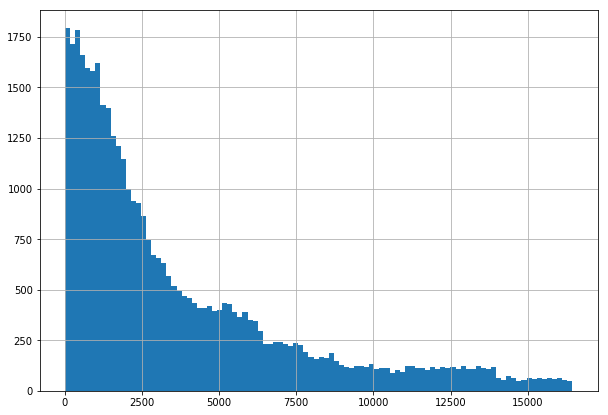

In [57]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

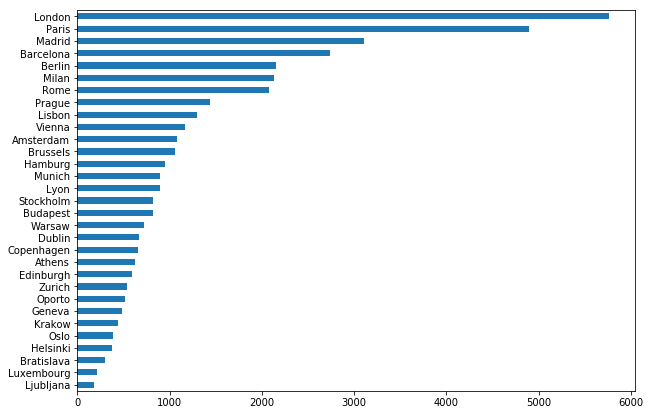

In [58]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

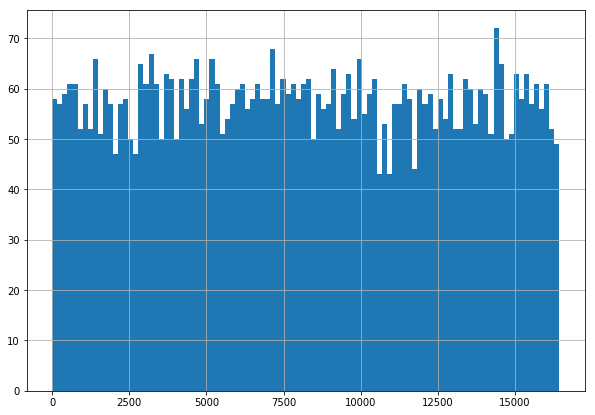

In [59]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

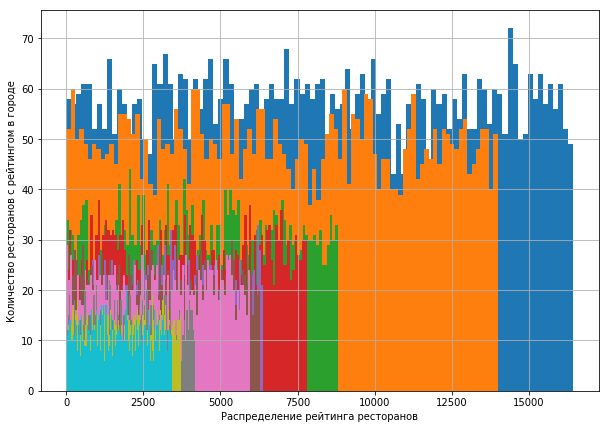

In [60]:
# Посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.ylabel('Количество ресторанов с рейтингом в городе')
plt.xlabel('Распределение рейтинга ресторанов')
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

Можно получить новый признак для модели, если признак ranking нормировать относительно его максимального значения в датасете.

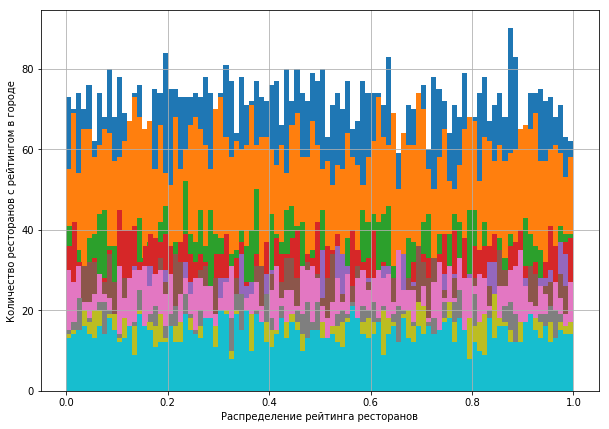

In [61]:
for x in (data['city_copy'].value_counts())[0:10].index:
    data['ranking'][data['city_copy'] == x].hist(bins=100)
plt.ylabel('Количество ресторанов с рейтингом в городе')
plt.xlabel('Распределение рейтинга ресторанов')
plt.show()

### Посмотрим распределение целевой переменной

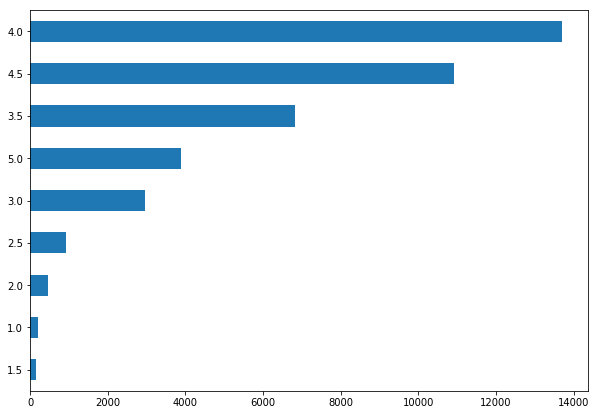

In [62]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

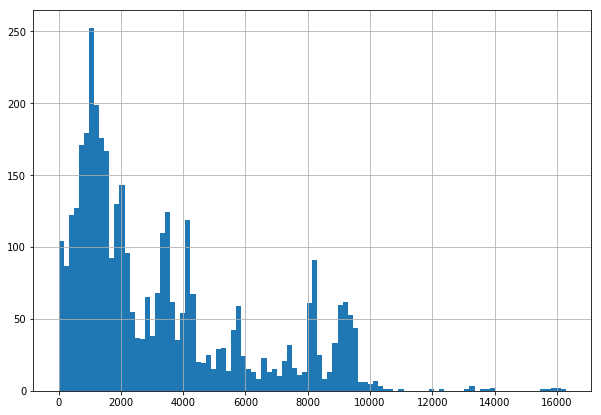

In [63]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

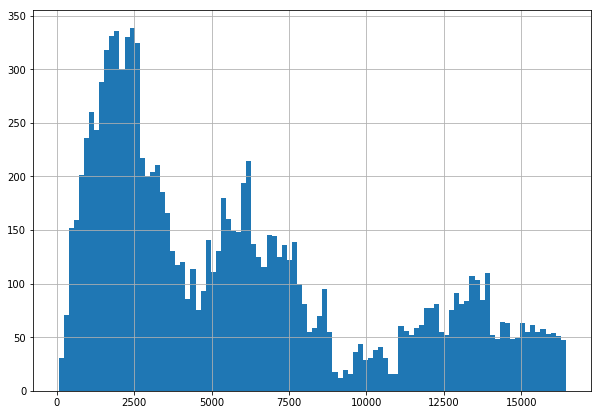

In [64]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### Сопоставим города и рейтинги при помощи boxplot

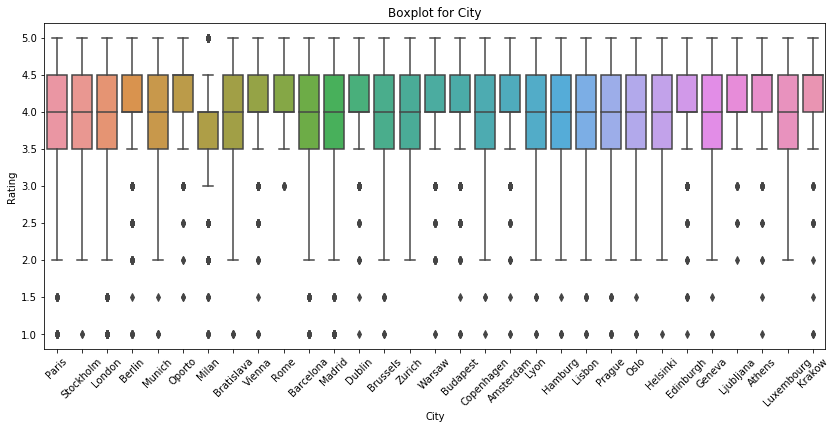

In [65]:
# Рейтинг по городам:
fig, ax = plt.subplots(figsize=(14, 6))
sns.boxplot(x='City', y='Rating', data=df_train, ax=ax)
plt.xticks(rotation=45)
ax.set_title('Boxplot for ' + 'City')
plt.show()

На боксплоте видно, что среднее значение рейтинга 4.0, не зависит от города. Точки -"выбросы" выбросами не считаем, так как они вписываются в диапазон 0...5.

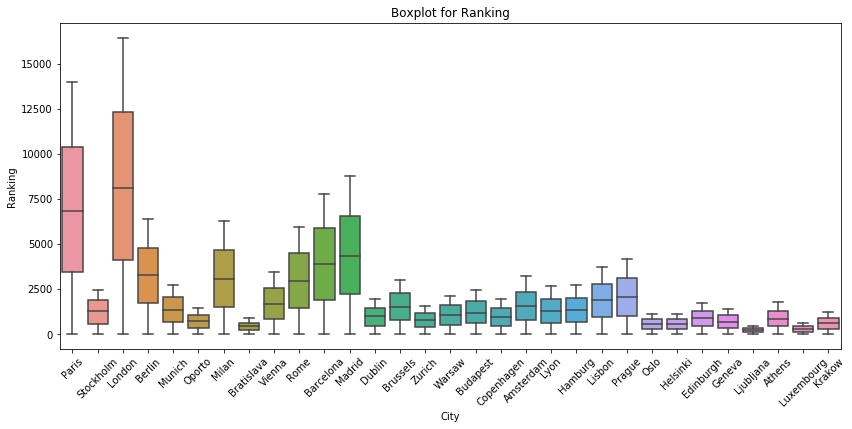

In [66]:
# Ранги ресторанов по городам
fig, ax = plt.subplots(figsize=(14, 6))
sns.boxplot(x='City', y='Ranking', data=df_train, ax=ax)
plt.xticks(rotation=45)
ax.set_title('Boxplot for ' + 'Ranking')
plt.show()

Видно, что абсолютные значения ранга сильно зависят от размера города (количества ресторанов в нем). Посмотрим теперь в относительных значениях.

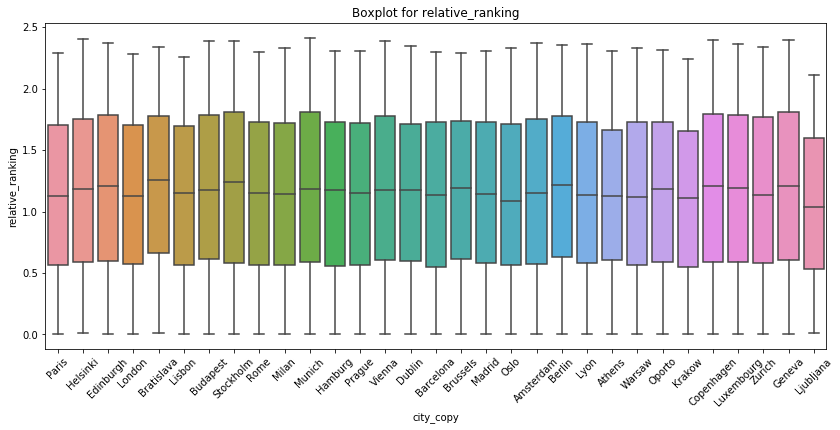

In [67]:
# Относительный ранг ресторанов по городам
# его берем не из датасета df_train, а из датасета data,
# так как в data создан новый признак -
# "отношение ранга ресторана к количеству ресторанов в этом городе"
fig, ax = plt.subplots(figsize=(14, 6))
sns.boxplot(x='city_copy', y='relative_ranking', data=data, ax=ax)
plt.xticks(rotation=45)
ax.set_title('Boxplot for ' + 'relative_ranking')
plt.show()

Видно, что распределение относительного ранга практически не зависит от города

### Эксперементальным путем подбираем переменные для модели.

In [68]:
for_drop = ['Afghani', 'African', 'Albanian', 'American', 'Arabic',
       'Argentinean', 'Armenian', 'Asian', 'Australian', 'Austrian',
       'Azerbaijani', 'Balti', 'Bangladeshi', 'Bar', 'Barbecue',
       'Belgian', 'Brazilian', 'Brew Pub', 'British', 'Burmese', 'Cafe',
       'Cajun & Creole', 'Cambodian', 'Canadian', 'Caribbean',
       'Caucasian', 'Central American', 'Central Asian',
       'Central European', 'Chilean', 'Chinese', 'Colombian',
       'Contemporary', 'Croatian', 'Cuban', 'Czech', 'Danish',
       'Delicatessen', 'Diner', 'Dutch', 'Eastern European', 'Ecuadorean',
       'Egyptian', 'Ethiopian', 'European', 'Fast Food', 'Filipino',
       'French', 'Fujian', 'Fusion', 'Gastropub', 'Georgian', 'German',
       'Gluten Free Options', 'Greek', 'Grill', 'Halal', 'Hawaiian',
       'Healthy', 'Hungarian', 'Indian', 'Indonesian', 'International',
       'Irish', 'Israeli', 'Italian', 'Jamaican', 'Japanese', 'Korean',
       'Kosher', 'Latin', 'Latvian', 'Lebanese', 'Local', 'Malaysian',
       'Mediterranean', 'Mexican', 'Middle Eastern', 'Minority Chinese',
       'Mongolian', 'Moroccan', 'Native American', 'Nepali',
       'New Zealand', 'Norwegian', 'Pakistani', 'Persian', 'Peruvian',
       'Pizza', 'Polish', 'Polynesian', 'Portuguese', 'Pub', 'Romanian',
       'Russian', 'Salvadoran', 'Scandinavian', 'Scottish', 'Seafood',
       'Singaporean', 'Slovenian', 'Soups', 'South American',
       'Southwestern', 'Spanish', 'Sri Lankan', 'Steakhouse',
       'Street Food', 'Sushi', 'Swedish', 'Swiss', 'Taiwanese', 'Thai',
       'Tibetan', 'Tunisian', 'Turkish', 'Ukrainian', 'Uzbek',
       'Vegan Options', 'Vegetarian Friendly', 'Venezuelan', 'Vietnamese',
       'Welsh', 'Wine Bar', 'Xinjiang', 'Yunnan', 'review_1',
       'review_2', 'rank_city_max', 'ranking']

data = data.drop(for_drop, axis=1)
data.sample(3)

,restaurant_id,cuisine_style,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,number_of_reviews_isnan,price_range_isnan,cuisine_style_isnan,city_copy,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,...,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,len_cuisines,cuisine_style_1,cuisine_style_2,review_delta,how_old_review,ranking_copy,rating_mean_per_city,rank_city_min,rank_norm,relative_ranking,population,review_to_population,rel_rank_to_population
8980,id_8980,[Local],2,8.0,"[[], []]",/Restaurant_Review-g189158-d8665695-Reviews-Ch...,d8665695,0,0.0,0,1,1,Lisbon,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,4,50,2350.0,0.502376,0.000269,0.632131,1.426837,3000,0.002667,0.000476
47638,id_2242,"[Czech, European]",2,11.0,"[['Stop here on away to metro', 'Best place on...",/Restaurant_Review-g274707-d7680632-Reviews-U_...,d7680632,1,4.0,0,0,0,Prague,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,2,1,0,152,227,2247.0,0.498324,0.000478,0.536312,1.237335,1301,0.008455,0.000951
43107,id_1071,"[Austrian, Central European, European]",2,24.0,"[['Lovely traditional Viennese food', 'One of ...",/Restaurant_Review-g190454-d5449369-Reviews-We...,d5449369,1,4.5,0,0,0,Vienna,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,3,1,0,114,222,1072.0,0.496886,0.000290,0.311066,0.742897,1897,0.012652,0.000392


## Матрица корреляций

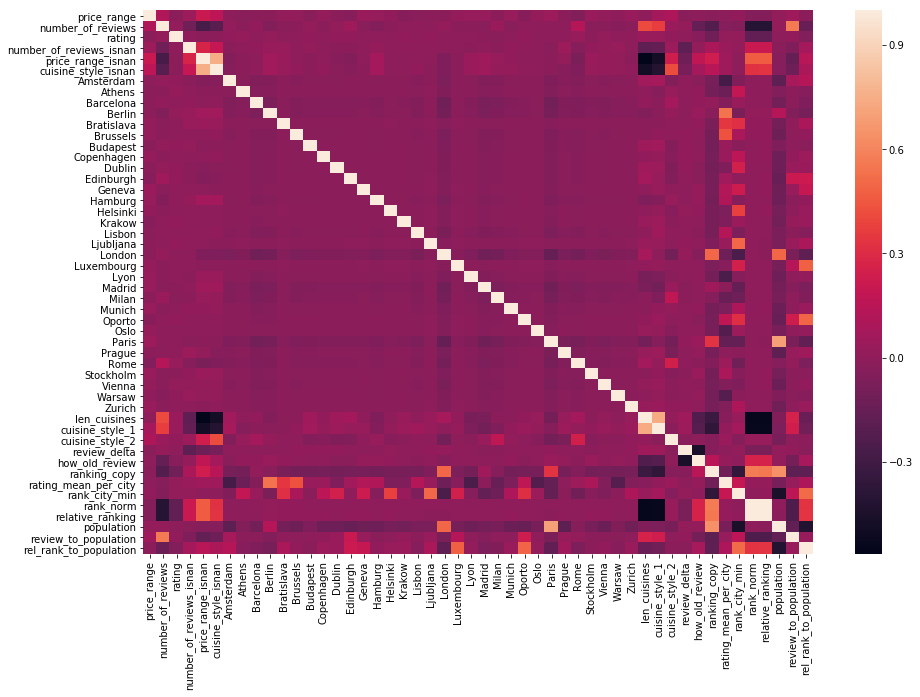

In [69]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Из матрицы видно, что нет ни одного признака, от которого сильно зависит целевая переменная '**rating**'. Есть корреляция между признаками '**price_range_isnan**' и '**cuisine_style_isnan**'. Вероятно, по одним и тем же ресторанам есть пропуски в данных по ценам и по кухням одновременно. Есть зависимость между признаками  '**rank_norm**' и '**relative_ranking**', но если хоть один из этих признаков убрать, то заметно падает **MAE**. 

# Data Preprocessing

#### Запускаем и проверяем что получилось

In [70]:
df_preproc = data.copy()

# Убираем признаки, которые еще не успели обработать,
# модель на признаках с dtypes "object" обучаться не будет,
# просто выберим их и удалим
object_columns = [
    s for s in df_preproc.columns if df_preproc[s].dtypes == 'object']
df_preproc.drop(object_columns, axis=1, inplace=True)

df_preproc.sample(3)

,price_range,number_of_reviews,sample,rating,number_of_reviews_isnan,price_range_isnan,cuisine_style_isnan,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,...,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,len_cuisines,cuisine_style_1,cuisine_style_2,review_delta,how_old_review,ranking_copy,rating_mean_per_city,rank_city_min,rank_norm,relative_ranking,population,review_to_population,rel_rank_to_population
22272,2,120.0,1,4.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,2,1,0,16,65,354.0,0.496107,0.000215,0.025102,0.057957,10620,0.011299,0.000005
17497,2,25.0,1,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,146,1091,1017.0,0.506762,0.002695,0.684459,1.584112,237,0.105485,0.006684
7491,2,15.0,0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,-1407,1461,13637.0,0.496107,0.000215,0.975041,2.232646,10620,0.001412,0.000210


In [71]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 51 columns):
price_range                50000 non-null uint8
number_of_reviews          50000 non-null float64
sample                     50000 non-null int64
rating                     50000 non-null float64
number_of_reviews_isnan    50000 non-null uint8
price_range_isnan          50000 non-null uint8
cuisine_style_isnan        50000 non-null uint8
Amsterdam                  50000 non-null uint8
Athens                     50000 non-null uint8
Barcelona                  50000 non-null uint8
Berlin                     50000 non-null uint8
Bratislava                 50000 non-null uint8
Brussels                   50000 non-null uint8
Budapest                   50000 non-null uint8
Copenhagen                 50000 non-null uint8
Dublin                     50000 non-null uint8
Edinburgh                  50000 non-null uint8
Geneva                     50000 non-null uint8
Hamburg                

In [72]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values  # наш таргет
X = train_data.drop(['rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [73]:
# Воспользуемся специальной функцие train_test_split для
# разбивки тестовых данных выделим 20% данных на валидацию
# (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [74]:
# Проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 50), (40000, 50), (40000, 49), (32000, 49), (8000, 49))

# Model 
Сам ML

In [75]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

In [76]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [77]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой
# выборке. Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [78]:
# Округление рейтинга до 0.5
y_pred = (y_pred*2).round()/2
y_pred

array([4.5, 5. , 4.5, ..., 4.5, 4.5, 4. ])

In [89]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test),
# и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее
# отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1678125


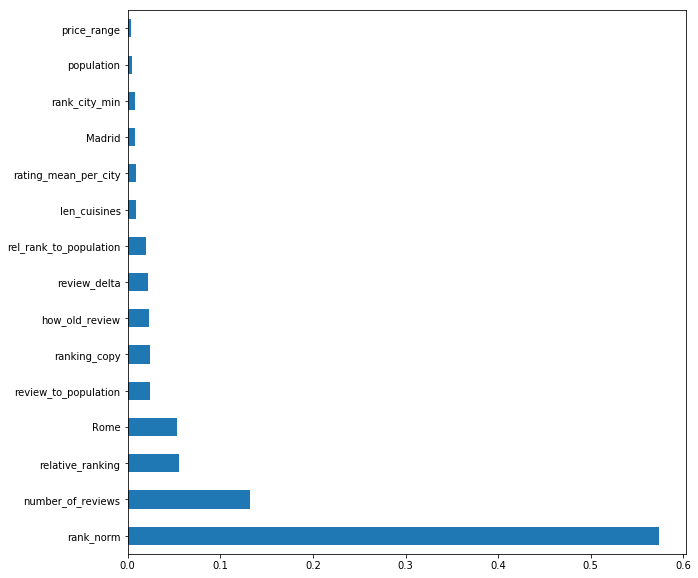

In [80]:
# В RandomForestRegressor можно вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Готовим Submission на kaggle

In [81]:
test_data.sample(10)

,price_range,number_of_reviews,rating,number_of_reviews_isnan,price_range_isnan,cuisine_style_isnan,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,len_cuisines,cuisine_style_1,cuisine_style_2,review_delta,how_old_review,ranking_copy,rating_mean_per_city,rank_city_min,rank_norm,relative_ranking,population,review_to_population,rel_rank_to_population
6481,2,13.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-56,110,4596.0,0.497617,0.000641,0.589270,1.353756,3186,0.004080,0.000425
8175,2,209.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2,1,19,151,1321.0,0.510894,0.000314,0.207064,0.488355,6177,0.033835,0.000079
7200,2,47.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,300,726,1114.0,0.495392,0.000804,0.895414,2.010830,1200,0.039167,0.001676
2255,2,22.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,206,201,5959.0,0.496107,0.000215,0.425946,0.975606,10620,0.002072,0.000092
5004,1,46.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,0,16,54,3291.0,0.496820,0.000061,0.200085,0.457528,8416,0.005466,0.000054
7856,2,4.0,0.0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,88,852,4047.0,0.510894,0.000314,0.635008,1.496118,6177,0.000648,0.000242
4648,2,15.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,50,6106.0,0.498186,0.000114,0.693120,1.601364,3266,0.004593,0.000490
5993,2,8.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,1,30,24,2168.0,0.512941,0.000998,0.720946,1.649924,1831,0.004369,0.000901
2291,2,2.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,-423,477,2109.0,0.502376,0.000269,0.567277,1.280510,3000,0.000667,0.000427
7714,2,152.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,4,50,2880.0,0.499451,0.000168,0.484110,1.112399,3900,0.038974,0.000285


In [82]:
test_data.columns

Index(['price_range', 'number_of_reviews', 'rating', 'number_of_reviews_isnan',
       'price_range_isnan', 'cuisine_style_isnan', 'Amsterdam', 'Athens',
       'Barcelona', 'Berlin', 'Bratislava', 'Brussels', 'Budapest',
       'Copenhagen', 'Dublin', 'Edinburgh', 'Geneva', 'Hamburg', 'Helsinki',
       'Krakow', 'Lisbon', 'Ljubljana', 'London', 'Luxembourg', 'Lyon',
       'Madrid', 'Milan', 'Munich', 'Oporto', 'Oslo', 'Paris', 'Prague',
       'Rome', 'Stockholm', 'Vienna', 'Warsaw', 'Zurich', 'len_cuisines',
       'cuisine_style_1', 'cuisine_style_2', 'review_delta', 'how_old_review',
       'ranking_copy', 'rating_mean_per_city', 'rank_city_min', 'rank_norm',
       'relative_ranking', 'population', 'review_to_population',
       'rel_rank_to_population'],
      dtype='object')

In [83]:
test_data = test_data.drop(['rating'], axis=1)

In [84]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [85]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [86]:
predict_submission

array([3.06 , 4.25 , 4.4  , ..., 3.07 , 4.5  , 4.335])

In [87]:
# округление рейтинга до 0.5
predict_submission = (predict_submission * 2).round() / 2
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [88]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5


# Выводы

В данном проекте был проанализирован и подготовлен к моделированию датасет с информацией по ресторанам от **TripAdvisor**. Работа заключалась в очистке данных, заполнении пропусков и создании новых признаков с целью уменьшить ошибку прогноза рейтинга ресторана. Категориальные признаки, по возможности, были переведены в числовой формат для использования в модели ML.

В датасете были обнаружены пропуски данных в признаках '**number_of_reviews**', '**price_range**' и '**cuisine_style**'. Пропуски были заполнены, при этом были созданы новые признаки '**isnan**' с информацией об отсутствии данных.

Категориальный признак '**city**' включает в себя 31 город. Больше всего ресторанов (7193) - в Лондоне. Признак был закодирован при помощи функции **get_dummies**.

Ордерный признак '**price_range**' - 3 градации - заменили последовательными числами 1, 2, 3. Больше всего ресторанов - в среднем ценовом диапазоне.

Категориальный признак '**cuisine_style**': в датасете 125 уникальных кухонь. Самые распространенные - вегетарианская и европейская. На его основе были созданы новые признаки с количеством кухонь в ресторане и группами кухонь.

Из признака '**reviews**' были извлечены даты отзывов. Создан признак с разницей в днях между двумя отзывами, а также признак "старость ревью относительно самого свежего в днях".

Созданы новые признаки: '**relative_ranking**' - отношение ранга ресторана к количеству ресторанов в этом городе по данным датасета И '**rank_norm**' - нормированный '**ranking**'. Важно: в итоге '**rank_norm**' внес наибольший вклад в повышение точности моделирования.

Для создания нового признака '**population**' была найдена в интернете информация о населении городов датасета и введена вручную в виде словаря. На основании этого созданы новые относительные признаки: '**review_to_population**' (отношение количества отзывов к населению) и '**rel_rank_to_population**' (отношение относительного ранга к населению).

Было произведено моделирование с использованием алгоритма машинного обучения "**RandomForestRegression**". Округление результатов моделирования (до 0.5, как шаг '**rating**' в исходном датасете) уменьшило абсолютную ошибку. Метрика **Mean Absolute Error** показала отклонение **MAE=0.1678125** от фактических значений. Это меньше, чем **MAE** из **baseline notebook**.

Таким образом, описанная выше обработка и feature engineering дали свой эффект и повысили точность моделирования.